# Testing U-net testing Malaria Images

Testing U-net with images of P. vivax (malaria) infected human blood smears

https://www.kaggle.com/kmader/malaria-bounding-boxes

In [1]:
import numpy as np
import os
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from datetime import date

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


## Loading Images

### Parameters

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '../../data/raw_data/malaria/transformed_images/'
TEST_PATH = 'stage1_test/'

MASK_CATEGORIES = ['trophozoite','ring', 'schizont', 'gametocyte']
STR_MASK_CATEGORIES = '_'.join(MASK_CATEGORIES)

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
train_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy')
X_train = np.load(TRAIN_PATH+'malaria_train_transformed_256_256.npy')
Y_train =  np.load(TRAIN_PATH+'malaria_train_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy')

In [4]:
test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy')
X_test = np.load(TRAIN_PATH+'malaria_test_transformed_256_256.npy')
Y_test =  np.load(TRAIN_PATH+'malaria_test_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy')

In [5]:
print(X_train.shape)
print(Y_train.shape)

(1208, 256, 256, 3)
(1208, 256, 256, 1)


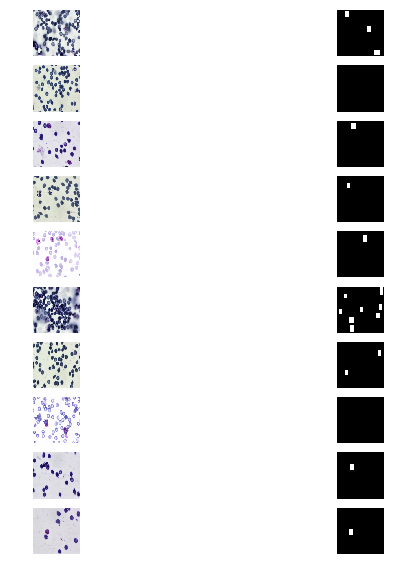

In [6]:
n_images = 10
fig, axes = plt.subplots(n_images,2,figsize=(10,10))
for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    ix = i
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

### IoU (Intersection of the union)
The intersection of the union(IOU): Measure the total number of shared pixels after applying the masks

\begin{equation*}
  IOU = \frac{I_1 \cup I_2}{I_1 \cap I_2}
\end{equation*}

In [7]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

In [8]:
def iou_loss_core2(y_true, y_pred, smooth=0):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [9]:
def get_metrics_grafics(results):
    # 'val_loss', 'val_my_iou_metric', 'loss', 'iou_loss_core'
    plt.figure(figsize=(20,10))
    ## LOSS
    plt.subplot(221)
    plt.plot(results.history['loss'], label='Training loss')
    plt.plot(results.history['val_loss'], label='Validation loss')
    plt.legend(frameon=False)
    ## Intersection over union
    plt.subplot(222)
    plt.plot(results.history['iou_loss_core'], label='Training IoU')
    plt.plot(results.history['val_iou_loss_core'], label='Validation IoU')
    plt.legend(frameon=False)

    plt.show()

## U-Net

![title](../../u-net-architecture.png)

In [10]:
def unet(input_size = (128,128,3), dropout_rate=0.2, learning_rate=0.004):
    inputs = Input(input_size)

    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(rate=dropout_rate)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(rate=dropout_rate)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    model.compile(optimizer = Adam(lr = learning_rate), loss = 'binary_crossentropy', metrics = [iou_loss_core,iou_loss_core2])

    return model

In [11]:
MODEL_ID = 0
TODAY =  date.today().strftime("%Y%m%d")

### Test Model

In [12]:
model = unet(input_size = (IMG_HEIGHT,IMG_WIDTH,3), dropout_rate=0.2, learning_rate=0.0004)

#model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model_name = "model-unet-malaria-kaggle-" + TODAY + "_" + str(MODEL_ID)+".h5"
print(model_name)

model-unet-malaria-kaggle-20190712_0.h5


In [14]:
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)


results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 966 samples, validate on 242 samples
Epoch 1/50
966/966 [==============================] - 44s 46ms/step - loss: 0.0869 - iou_loss_core: 0.0132 - iou_loss_core2: nan - val_loss: 0.0741 - val_iou_loss_core: 0.0010 - val_iou_loss_core2: nan

Epoch 00001: val_loss improved from inf to 0.07405, saving model to model-unet-malaria-kaggle-20190712_0.h5
Epoch 2/50
966/966 [==============================] - 38s 40ms/step - loss: 0.0654 - iou_loss_core: 0.0016 - iou_loss_core2: nan - val_loss: 0.0638 - val_iou_loss_core: 0.0020 - val_iou_loss_core2: 0.0020

Epoch 00002: val_loss improved from 0.07405 to 0.06377, saving model to model-unet-malaria-kaggle-20190712_0.h5
Epoch 3/50
966/966 [==============================] - 38s 40ms/step - loss: 0.0591 - iou_loss_core: 0.0036 - iou_loss_core2: nan - val_loss: 0.0582 - val_iou_loss_core: 0.0022 - val_iou_loss_core2: 0.0021

Epoch 00003: val_loss improved from 0.06377 to 0.05822, saving model to

Epoch 29/50
966/966 [==============================] - 37s 39ms/step - loss: 0.0137 - iou_loss_core: 0.3923 - iou_loss_core2: nan - val_loss: 0.0273 - val_iou_loss_core: 0.5665 - val_iou_loss_core2: nan

Epoch 00029: val_loss did not improve from 0.02426
Epoch 30/50
966/966 [==============================] - 37s 39ms/step - loss: 0.0130 - iou_loss_core: 0.5790 - iou_loss_core2: nan - val_loss: 0.0293 - val_iou_loss_core: 0.5148 - val_iou_loss_core2: nan

Epoch 00030: val_loss did not improve from 0.02426
Epoch 31/50
966/966 [==============================] - 37s 39ms/step - loss: 0.0126 - iou_loss_core: 0.6774 - iou_loss_core2: nan - val_loss: 0.0247 - val_iou_loss_core: 0.3251 - val_iou_loss_core2: nan

Epoch 00031: val_loss did not improve from 0.02426
Epoch 32/50
966/966 [==============================] - 37s 39ms/step - loss: 0.0122 - iou_loss_core: 0.6132 - iou_loss_core2: nan - val_loss: 0.0274 - val_iou_loss_core: 0.6740 - val_iou_loss_core2: nan

Epoch 00032: val_loss did not i

In [ ]:
MODEL_ID +=1

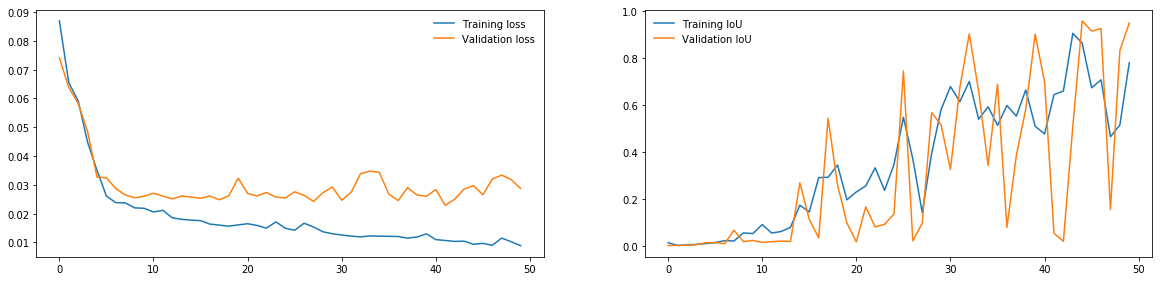

In [15]:
get_metrics_grafics(results)

In [16]:
results_test = model.evaluate(x = X_test, y = Y_test)

120/120 [==============================] - 5s 39ms/step


In [17]:
results_test

[0.18331354359785715, 0.7404342134793599, nan]

## Predictions

In [18]:
# Predict on train, val and test
model = load_model(model_name, custom_objects={'iou_loss_core': iou_loss_core, 'iou_loss_core2':iou_loss_core2})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (X_test[i].shape[0], X_test[i].shape[1]), 
                                       mode='constant', preserve_range=True))

120/120 [==============================] - 1s 11ms/step


### IMAGE |  MASK | PREDICTION

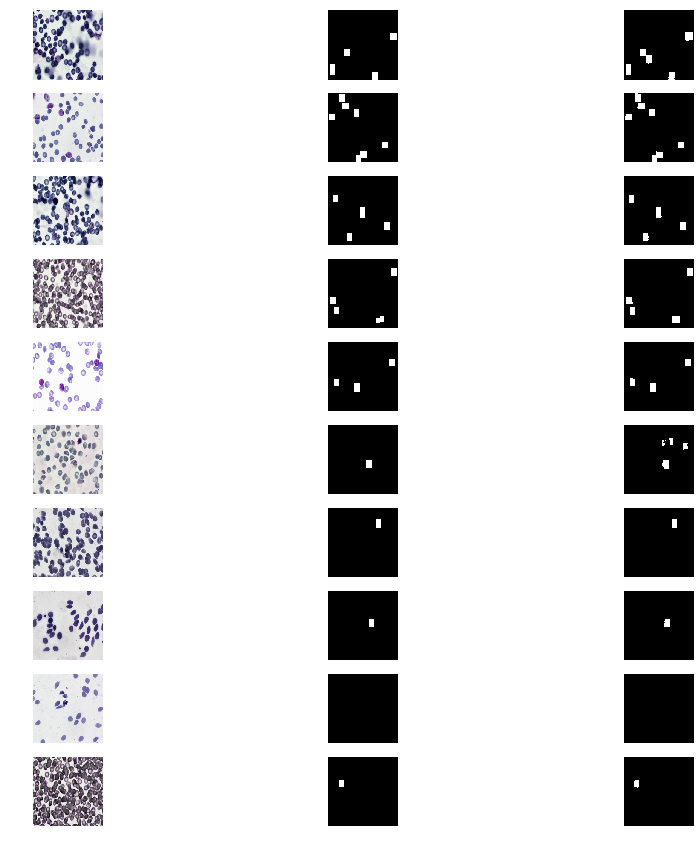

In [19]:
n_images = 10

fig, axes = plt.subplots(n_images,3,figsize=(15,15))

for i in range(n_images):
    ix = random.randint(0, len(preds_train_t-1))
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
    axes[i,2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

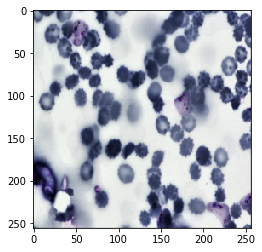

In [20]:
plt.imshow(X_train[0] )

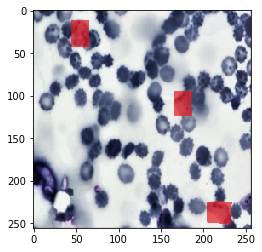

In [21]:
plt.imshow(X_train[0] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[0]>0, 1, np.nan)), cmap='Set1',alpha=0.7)


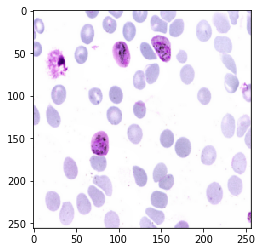

In [22]:
plt.imshow(X_train[4] ) 

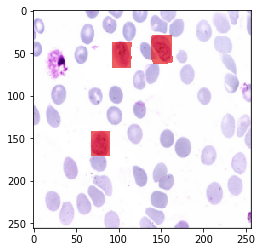

In [23]:
plt.imshow(X_train[4] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[4]>0,1, np.nan)), cmap='Set1',alpha=0.7)

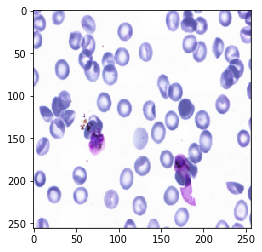

In [24]:
plt.imshow(X_train[7] ) 

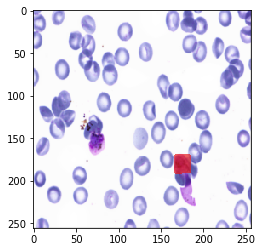

In [25]:
plt.imshow(X_train[7] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[7]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

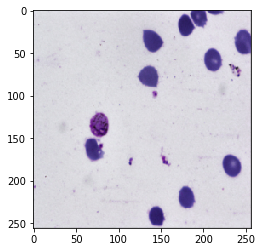

In [26]:
plt.imshow(X_train[9] )

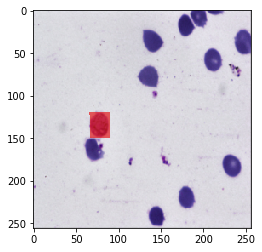

In [27]:
plt.imshow(X_train[9] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[9]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

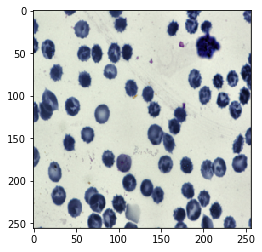

In [28]:
plt.imshow(X_train[50] ) 

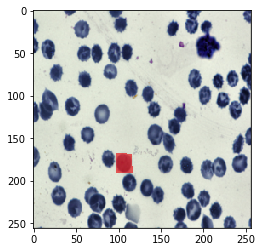

In [29]:
plt.imshow(X_train[50] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[50]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

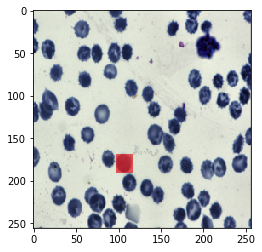

In [30]:
plt.imshow(X_train[50] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(Y_train[50]>0, 1, np.nan)), cmap='Set1',alpha=0.7)